The point of this notebook is to see how to quickly get tensors onto the device and processed. I primarily want to check out:

* Test out various copying methods, like built-in `[:]=` numpy's `np.copyto()`, torch's `.copy_()`, pycuda's `memcpy_htod()` and `memcpy_dtoh()`
* Copy array as `uint8` onto gpu first, then convert to `float` and process
* Convert array to `float` first then copy it to gpu
* The effects of using pinned memory

In [1]:
import pycuda.autoinit
import pycuda.driver as cuda

import torch
import numpy as np
import matplotlib.pyplot as plt

# Get example image

In [2]:
X = np.fromfile('test.raw', dtype=np.uint8).reshape(384, 512)

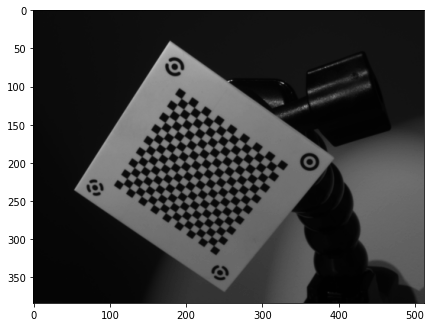

In [3]:
plt.figure(figsize=(7,7))
plt.imshow(X, vmin=0, vmax=255, cmap='gray')

# Allocate buffers

Buffers for transferring data onto gpu

In [4]:
X_h_uint8_u_torch = torch.empty((384, 512), dtype=torch.uint8)
X_h_uint8_p_torch = torch.empty((384, 512), dtype=torch.uint8, pin_memory=True)
X_h_float_u_torch = torch.empty((384, 512), dtype=torch.float)
X_h_float_p_torch = torch.empty((384, 512), dtype=torch.float, pin_memory=True)
X_d_uint8_torch   = torch.empty((384, 512), dtype=torch.uint8, device='cuda')
X_d_float_torch   = torch.empty((384, 512), dtype=torch.float, device='cuda')

In [5]:
X_h_uint8_u_pycuda = np.empty((384, 512), dtype=np.uint8)
X_h_uint8_p_pycuda = cuda.pagelocked_empty(384*512, dtype=np.uint8)
X_h_float_u_pycuda = np.empty((384, 512), dtype=np.float)
X_h_float_p_pycuda = cuda.pagelocked_empty(384*512, dtype=np.float32)
X_d_uint8_pycuda   = cuda.mem_alloc(384*512)
X_d_float_pycuda   = cuda.mem_alloc(384*512*4)

# Check torch's from_numpy

In [6]:
%%timeit
torch.from_numpy(X)

945 ns ± 4.82 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Very fast

# Check [:]= vs np.copyto

In [6]:
%%timeit
X_h_uint8_u_pycuda[:] = X

5.31 µs ± 19.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
%%timeit
np.copyto(X_h_uint8_u_pycuda, X)

5.8 µs ± 29.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


[:]= seems to be a little faster

# Check host to device transfer with different torch methods and pinned/unpinned memory and same dtype

In [6]:
%%timeit
X_d_uint8_torch.copy_(X_h_uint8_u_torch)

34 µs ± 667 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%%timeit
X_d_uint8_torch.copy_(X_h_uint8_p_torch)

25.9 µs ± 420 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
%%timeit
X_d_uint8_torch[:] = X_h_uint8_u_torch

37.6 µs ± 323 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%%timeit
X_d_uint8_torch[:] = X_h_uint8_p_torch

29 µs ± 269 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%%timeit
X_h_uint8_u_torch.to('cuda')

39.5 µs ± 190 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%%timeit
X_h_uint8_p_torch.to('cuda')

32.3 µs ± 660 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Seems `copy_` with pinned memory is the fastest

# Check pycuda's memcpy method

In [6]:
%%timeit
cuda.memcpy_htod(X_d_uint8_pycuda, X_h_uint8_u_pycuda)

30.2 µs ± 450 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%%timeit
cuda.memcpy_htod(X_d_uint8_pycuda, X_h_uint8_p_pycuda)

24.2 µs ± 421 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Slightly faster than torch's `copy_` method

# Check copying uint8 to float on host, then transferring it to gpu

In [6]:
%%timeit
X_h_float_p_torch.copy_(torch.from_numpy(X))
X_d_float_torch.copy_(X_h_float_p_torch)

104 µs ± 190 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
%%timeit
X_h_float_p_pycuda[:] = X.reshape(-1)
cuda.memcpy_htod(X_d_float_pycuda, X_h_float_p_pycuda)

120 µs ± 912 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


`X_h_float_p_pycuda[:] = X.reshape(-1)` is slower then the `copy_`

# Check copying uint8 to device, then transferring it to gpu, then copying uint8 to float in gpu

In [8]:
%%timeit
X_d_uint8_torch.copy_(torch.from_numpy(X))
X_d_float_torch.copy_(X_d_uint8_torch)

45.2 µs ± 1.64 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%%timeit
X_h_uint8_p_torch.copy_(torch.from_numpy(X))
X_d_uint8_torch.copy_(X_h_uint8_p_torch)
X_d_float_torch.copy_(X_d_uint8_torch)

48.3 µs ± 245 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Running this seems to go back and forth between which one is faster, but basically page locked memory doesn't seem to be important for this case.